In [1]:
import sqlite3
import pandas as pd
import matplotlib as rc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# set style for seaborn
sns.set_style("whitegrid")
sns.set_context("paper")

WIDTH = 5.8
SMALL_HEIGHT = 3
MEDIUM_HEIGHT = 5
BIGGER_HEIGHT = 7

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

OUTPUT = "../output/graph/"

In [2]:
# connect to database
connection = sqlite3.connect("../output/db/bulk_analysis_2019-11-08_1000ms.db")


In [3]:
# load games and moves into dataframes 
df_game_dirty = pd.read_sql("SELECT * FROM game", connection)
df_move_dirty = pd.read_sql("SELECT * FROM move", connection)

# remove games that are either too short or too long
df_game = remove_outlier(df_game_dirty, "length")
df_move = df_move_dirty.query("ply_number <= 133")
df_move.head()


,id,fullmove_number,ply_number,turn,san,lan,score,score_change,score_change_category,move_count,...,guarded_pieces_centipawn_all,attacked_guarded_pieces_centipawn_all,unopposed_threats_centipawn_all,threats_centipawn_all,attack_defense_relation1,attack_defense_relation2,material,pawn_ending,rook_ending,game_id
0,1,1,1,1,d4,d2-d4,-10,10,0.20,20,...,5800,0,0,0,0,-600,0,0,0,1
1,2,1,2,0,g6,g7-g6,118,128,2.56,20,...,5800,0,0,0,0,-500,0,0,0,1
2,3,2,3,1,c4,c2-c4,37,81,1.62,28,...,5700,0,0,0,0,-1500,0,0,0,1
3,4,2,4,0,Bg7,Bf8-g7,106,69,1.38,21,...,5900,100,0,0,600,-2100,0,0,0,1
4,5,3,5,1,Nf3,Ng1-f3,43,63,1.26,30,...,5900,100,0,0,900,-1300,0,0,0,1


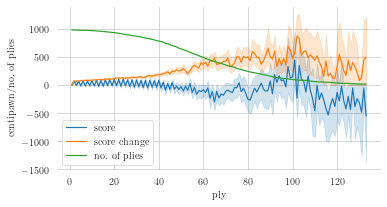

In [4]:
# Score vs. score change
f, ax = plt.subplots(figsize=(WIDTH, SMALL_HEIGHT), sharey=True)
line_score = sns.lineplot(x="ply_number", y="score", data=df_move, legend="brief")
sns.lineplot(x="ply_number", y="score_change", data=df_move)
line_plies = sns.lineplot(x="ply_number", y="count", data=df_move.groupby(["ply_number"]).size().reset_index(name="count"))
sns.despine(left=True, bottom=True)
line_score.set_xlabel("ply")
line_score.set_ylabel("centipawn/no. of plies")
ax.legend(labels=["score", "score change", "no. of plies"], loc=3)

In [5]:
f.tight_layout()
f.savefig(OUTPUT+"line_scorevschange.pdf")


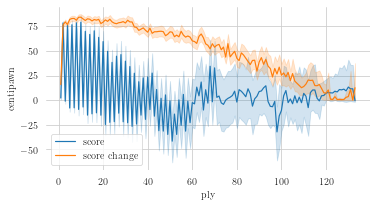

In [6]:
# Score vs. score change, excluding outliers
df_score = remove_outlier(df_move, "score")
df_score_change = remove_outlier(df_move, "score_change")
f, ax = plt.subplots(figsize=(WIDTH, SMALL_HEIGHT), sharey=True)
line_score = sns.lineplot(x="ply_number", y="score", data=df_score, legend="brief")
sns.lineplot(x="ply_number", y="score_change", data=df_score_change)
#line_plies = sns.lineplot(x="ply_number", y="count", data=df_move.groupby(["ply_number"]).size().reset_index(name="count"))
sns.despine(left=True, bottom=True)
line_score.set_xlabel("ply")
line_score.set_ylabel("centipawn")
ax.legend(labels=["score", "score change"], loc=3)

In [7]:
f.tight_layout()
f.savefig(OUTPUT+"line_scorevschange_cleaned.pdf")


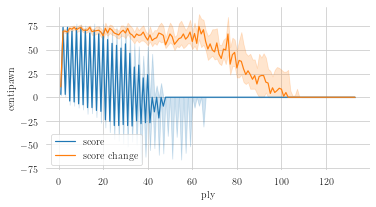

In [8]:
# Median score vs. median score change
f, ax = plt.subplots(figsize=(WIDTH, SMALL_HEIGHT), sharey=True)
line_score = sns.lineplot(x="ply_number", y="score", estimator=np.median, data=df_move, legend="brief")
sns.lineplot(x="ply_number", y="score_change", estimator=np.median, data=df_move)
#line_plies = sns.lineplot(x="ply_number", y="count", data=df_move.groupby(["ply_number"]).size().reset_index(name="count"))
sns.despine(left=True, bottom=True)
line_score.set_xlabel("ply")
line_score.set_ylabel("centipawn")
ax.legend(labels=["score", "score change"], loc=3)

In [9]:
f.tight_layout()
f.savefig(OUTPUT+"line_scorevschange_median.pdf")

In [10]:
df_move_dirty[["score","score_change"]].describe()

,score,score_change
count,62355.000000,62355.000000
mean,-6.892519,216.887724
std,950.148473,717.726142
min,-15321.000000,0.000000
25%,-113.000000,31.000000
50%,0.000000,64.000000
75%,132.000000,131.000000
max,15296.000000,15320.000000


In [11]:
df_move[["score","score_change"]].describe()

,score,score_change
count,62009.000000,62009.000000
mean,-6.833105,216.953910
std,946.905453,716.616333
min,-15321.000000,0.000000
25%,-115.000000,31.000000
50%,0.000000,65.000000
75%,132.000000,132.000000
max,15296.000000,15320.000000


In [12]:
df_score_change[["score","score_change"]].describe()

,score,score_change
count,54348.000000,54348.000000
mean,3.950964,69.709483
std,623.775698,60.406757
min,-15258.000000,0.000000
25%,-91.250000,26.000000
50%,0.000000,56.000000
75%,115.000000,96.000000
max,7655.000000,283.000000
